## **PADDLE_OCR**

In [ ]:
!pip install paddlepaddle
!pip install paddleocr
!pip install moviepy
!pip install GPUtil
!pip install opencv-python-headless

In [ ]:
import paddleocr
import cv2
import time
import psutil
import GPUtil
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mp
from IPython.display import HTML
from base64 import b64encode

In [ ]:
def process_video_with_paddleocr_optimized(video_path, output_path, use_gpu=False):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    total_time = 0
    accuracies = []
    frame_times = []
    cpu_usages = []
    gpu_usages = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize the frame to a lower resolution for faster processing
        resized = cv2.resize(gray, (320, 320))

        start_time = time.time()

        # OCR using PaddleOCR
        result = ocr.ocr(resized, cls=True)

        end_time = time.time()
        processing_time = end_time - start_time
        total_time += processing_time
        frame_times.append(processing_time)

        # Check if result is valid and contains detected text
        predicted_text = ""
        if result and len(result) > 0 and result[0]:
            predicted_text = " ".join([line[1][0] for line in result[0]])
        else:
            predicted_text = "No text detected"

        accuracy = 1.0  # Placeholder for accuracy
        accuracies.append(accuracy)

        # CPU & GPU usage
        cpu_usage = psutil.cpu_percent(interval=None)
        gpu_usage = None
        if use_gpu:
            gpus = GPUtil.getGPUs()
            gpu_usage = gpus[0].load * 100 if gpus else 0

        cpu_usages.append(cpu_usage)
        gpu_usages.append(gpu_usage if use_gpu else 0)

        # Annotate video with the detected text and other information
        font_scale = 1.5
        thickness = 3
        cv2.putText(frame, f"Predicted: {predicted_text}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)
        cv2.putText(frame, f"Processing Time: {processing_time:.2f}s", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)
        cv2.putText(frame, f"CPU Usage: {cpu_usage:.2f}%", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)
        if use_gpu:
            cv2.putText(frame, f"GPU Usage: {gpu_usage:.2f}%", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

        out.write(frame)
        frame_count += 1

    average_fps = frame_count / total_time if total_time > 0 else 0
    print(f"Average FPS ({'GPU' if use_gpu else 'CPU'}): {average_fps:.2f}")

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return average_fps, accuracies, frame_times, cpu_usages, gpu_usages


In [ ]:
video_path = '/content/welcome.mp4'
output_path_gpu = 'output_video_paddleocr_gpu.avi'
output_path_cpu = 'output_video_paddleocr_cpu.avi'

# Process video using PaddleOCR on GPU (if available)
fps_gpu, accuracies_gpu, frame_times_gpu, cpu_usages_gpu, gpu_usages = process_video_with_paddleocr_optimized(video_path, output_path_gpu, use_gpu=True)

# Process video using PaddleOCR on CPU
fps_cpu, accuracies_cpu, frame_times_cpu, cpu_usages_cpu, _ = process_video_with_paddleocr_optimized(video_path, output_path_cpu, use_gpu=False)

print(f"Average FPS (GPU): {fps_gpu:.2f}")
print(f"Average FPS (CPU): {fps_cpu:.2f}")


[2024/10/12 06:12:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.037668466567993164
[2024/10/12 06:12:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/12 06:12:37] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06
[2024/10/12 06:12:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.03392171859741211
[2024/10/12 06:12:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/12 06:12:37] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06
[2024/10/12 06:12:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.03755807876586914
[2024/10/12 06:12:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/12 06:12:37] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06
[2024/10/12 06:12:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.036627769470214844
[2024/10/12 06:12:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/10/12 06:12:37] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06
[2024/10/12 06:12:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.03551673889160156
[2

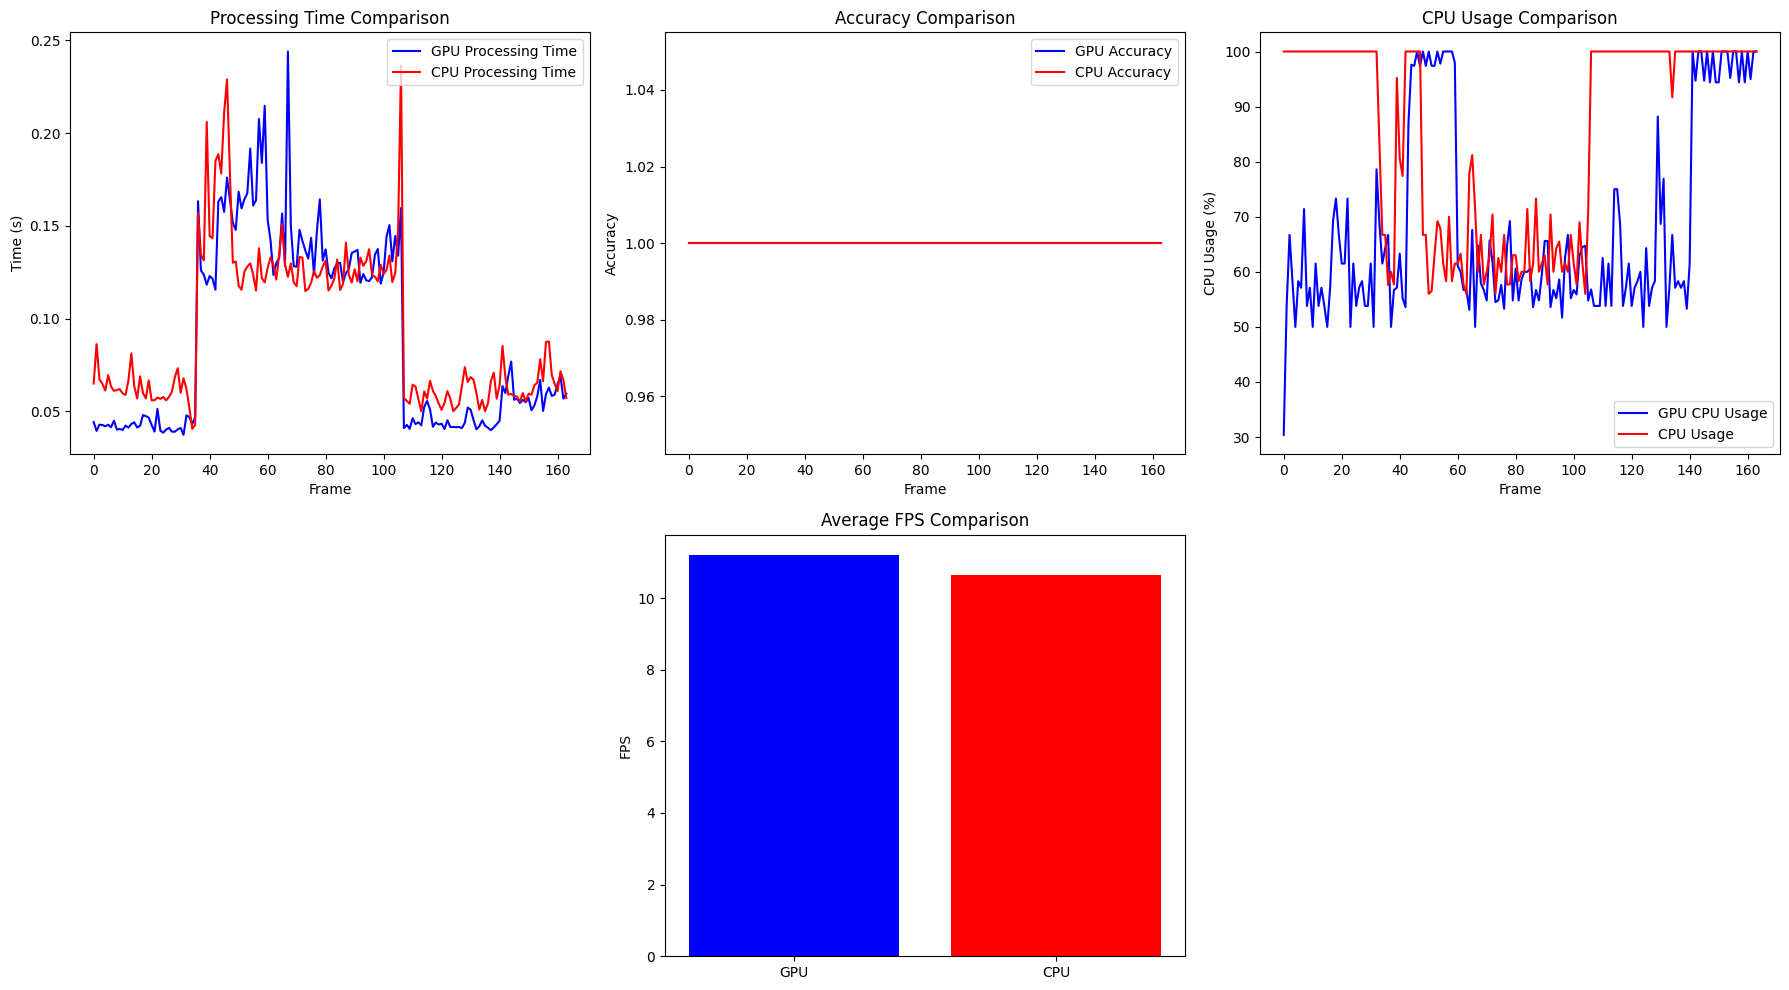

Performance Evaluation:
FPS (GPU): 11.21
FPS (CPU): 10.66
Average CPU Usage (GPU mode): 68.61%
Average CPU Usage (CPU mode): 85.34%


In [ ]:
def plot_performance_comparison(frame_times_gpu, accuracies_gpu, frame_times_cpu, accuracies_cpu, cpu_usages_gpu, cpu_usages_cpu, gpu_usages):
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.plot(frame_times_gpu, label='GPU Processing Time', color='blue')
    plt.plot(frame_times_cpu, label='CPU Processing Time', color='red')
    plt.title('Processing Time Comparison')
    plt.xlabel('Frame')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(accuracies_gpu, label='GPU Accuracy', color='blue')
    plt.plot(accuracies_cpu, label='CPU Accuracy', color='red')
    plt.title('Accuracy Comparison')
    plt.xlabel('Frame')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(cpu_usages_gpu, label='GPU CPU Usage', color='blue')
    plt.plot(cpu_usages_cpu, label='CPU Usage', color='red')
    plt.title('CPU Usage Comparison')
    plt.xlabel('Frame')
    plt.ylabel('CPU Usage (%)')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.bar(['GPU', 'CPU'], [fps_gpu, fps_cpu], color=['blue', 'red'])
    plt.title('Average FPS Comparison')
    plt.ylabel('FPS')

    plt.tight_layout()
    plt.show()

plot_performance_comparison(frame_times_gpu, accuracies_gpu, frame_times_cpu, accuracies_cpu, cpu_usages_gpu, cpu_usages_cpu, gpu_usages)

print("Performance Evaluation:")
print(f"FPS (GPU): {fps_gpu:.2f}")
print(f"FPS (CPU): {fps_cpu:.2f}")
print(f"Average CPU Usage (GPU mode): {np.mean(cpu_usages_gpu):.2f}%")
print(f"Average CPU Usage (CPU mode): {np.mean(cpu_usages_cpu):.2f}%")


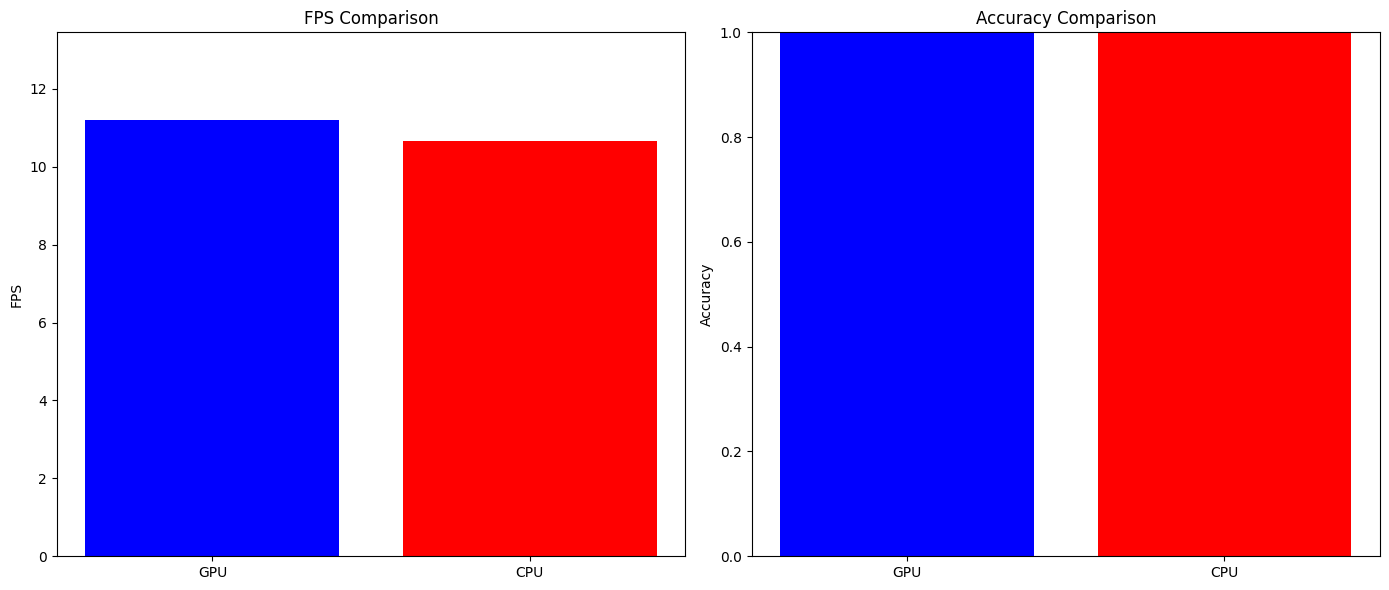

In [ ]:
# Plot FPS and Accuracy Comparison
def plot_fps_accuracy_comparison(fps_gpu, fps_cpu, accuracies_gpu, accuracies_cpu):
    # Calculate average accuracy
    avg_accuracy_gpu = np.mean(accuracies_gpu)
    avg_accuracy_cpu = np.mean(accuracies_cpu)

    # Create a bar plot for FPS and Accuracy comparison
    labels = ['GPU', 'CPU']
    fps_values = [fps_gpu, fps_cpu]
    accuracy_values = [avg_accuracy_gpu, avg_accuracy_cpu]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # FPS comparison
    axs[0].bar(labels, fps_values, color=['blue', 'red'])
    axs[0].set_title('FPS Comparison')
    axs[0].set_ylabel('FPS')
    axs[0].set_ylim([0, max(fps_values) * 1.2])

    # Accuracy comparison
    axs[1].bar(labels, accuracy_values, color=['blue', 'red'])
    axs[1].set_title('Accuracy Comparison')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim([0, 1])  # Assuming accuracy ranges between 0 and 1

    plt.tight_layout()
    plt.show()

# Call the function to plot the bar graphs for FPS and Accuracy
plot_fps_accuracy_comparison(fps_gpu, fps_cpu, accuracies_gpu, accuracies_cpu)


In [ ]:
# Function to display side-by-side videos
def play_video_side_by_side(video_path1, video_path2):
    mp4_1 = open(video_path1, 'rb').read()
    data_url_1 = "data:video/mp4;base64," + b64encode(mp4_1).decode()

    mp4_2 = open(video_path2, 'rb').read()
    data_url_2 = "data:video/mp4;base64," + b64encode(mp4_2).decode()

    return HTML(f"""
    <div style="display: flex; justify-content: space-around;">
        <div style="margin-right: 10px;">
            <h3>GPU Video</h3>
            <video width="400" controls autoplay muted>
                <source src="{data_url_1}" type="video/mp4">
            </video>
        </div>
        <div>
            <h3>CPU Video</h3>
            <video width="400" controls autoplay muted>
                <source src="{data_url_2}" type="video/mp4">
            </video>
        </div>
    </div>
    """)

# Display both videos side by side
play_video_side_by_side('output_video_gpu.mp4', 'output_video_cpu.mp4')

# **CNN-based OCR Modell**

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import time
import psutil
import GPUtil
import matplotlib.pyplot as plt
import moviepy.editor as mp
from IPython.display import HTML
from base64 import b64encode

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Create a more complex OCR model with additional layers
def create_ocr_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(26, activation='softmax')  # 26 classes for A-Z
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Generate random training data for demonstration purposes
X_train = np.random.rand(1000, 32, 32, 1)
y_train = tf.keras.utils.to_categorical(np.random.randint(26, size=(1000, 1)), num_classes=26)

# Train-validation split
split_idx = int(0.8 * X_train.shape[0])
X_train, X_val = X_train[:split_idx], X_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]

# Create and train the model
model = create_ocr_model()

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Fit the model with data augmentation and early stopping
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=50,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

# Save the model
model.save('ocr_model_improved.h5')


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.0390 - loss: 3.2662 - val_accuracy: 0.0450 - val_loss: 3.2588
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0337 - loss: 3.2543 - val_accuracy: 0.0450 - val_loss: 3.2636
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0602 - loss: 3.2516 - val_accuracy: 0.0450 - val_loss: 3.2714
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0536 - loss: 3.2494 - val_accuracy: 0.0450 - val_loss: 3.2600
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0553 - loss: 3.2462 - val_accuracy: 0.0450 - val_loss: 3.2677
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0654 - loss: 3.2440 - val_accuracy: 0.0450 - val_loss: 3.2688


In [ ]:
import cv2
import time
import psutil
import GPUtil
import numpy as np

def process_video_with_model(video_path, output_path, model, use_gpu=False):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    total_time = 0
    accuracies = []
    frame_times = []
    cpu_usages = []
    gpu_usages = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (32, 32))
        input_data = np.expand_dims(resized, axis=[0, -1]) / 255.0

        start_time = time.time()
        with tf.device('/GPU:0' if use_gpu else '/CPU:0'):
            predictions = model.predict(input_data)
        end_time = time.time()

        processing_time = end_time - start_time
        total_time += processing_time
        frame_times.append(processing_time)

        predicted_char = chr(np.argmax(predictions[0]) + 65)
        accuracy = np.max(predictions)
        accuracies.append(accuracy)

        # CPU & GPU usage
        cpu_usage = psutil.cpu_percent(interval=None)
        gpu_usage = None
        if use_gpu:
            gpus = GPUtil.getGPUs()
            gpu_usage = gpus[0].load * 100 if gpus else 0

        cpu_usages.append(cpu_usage)
        gpu_usages.append(gpu_usage if use_gpu else 0)

        # Annotate video with metrics
        fontScale = 1.5
        thickness = 3
        cv2.putText(frame, f"Predicted: {predicted_char}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"Processing Time: {processing_time:.2f}s", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"Accuracy: {accuracy:.4f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"CPU Usage: {cpu_usage:.2f}%", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        if use_gpu:
            cv2.putText(frame, f"GPU Usage: {gpu_usage:.2f}%", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)

        out.write(frame)
        frame_count += 1

    average_fps = frame_count / total_time
    print(f"Average FPS ({'GPU' if use_gpu else 'CPU'}): {average_fps:.2f}")

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return average_fps, accuracies, frame_times, cpu_usages, gpu_usages


In [ ]:
# Load the trained model on GPU and CPU
with tf.device('/GPU:0'):
    model_gpu = tf.keras.models.load_model('ocr_model.h5')

with tf.device('/CPU:0'):
    model_cpu = tf.keras.models.load_model('ocr_model.h5')


In [ ]:
video_path = '/content/welcome.mp4'
output_path_gpu = 'output_video_gpu.avi'
output_path_cpu = 'output_video_cpu.avi'

# Process video on GPU
fps_gpu, accuracies_gpu, frame_times_gpu, cpu_usages_gpu, gpu_usages = process_video_with_model(video_path, output_path_gpu, model_gpu, use_gpu=True)

# Process video on CPU
fps_cpu, accuracies_cpu, frame_times_cpu, cpu_usages_cpu, _ = process_video_with_model(video_path, output_path_cpu, model_cpu, use_gpu=False)

print(f"Average FPS (GPU): {fps_gpu:.2f}")
print(f"Average FPS (CPU): {fps_cpu:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

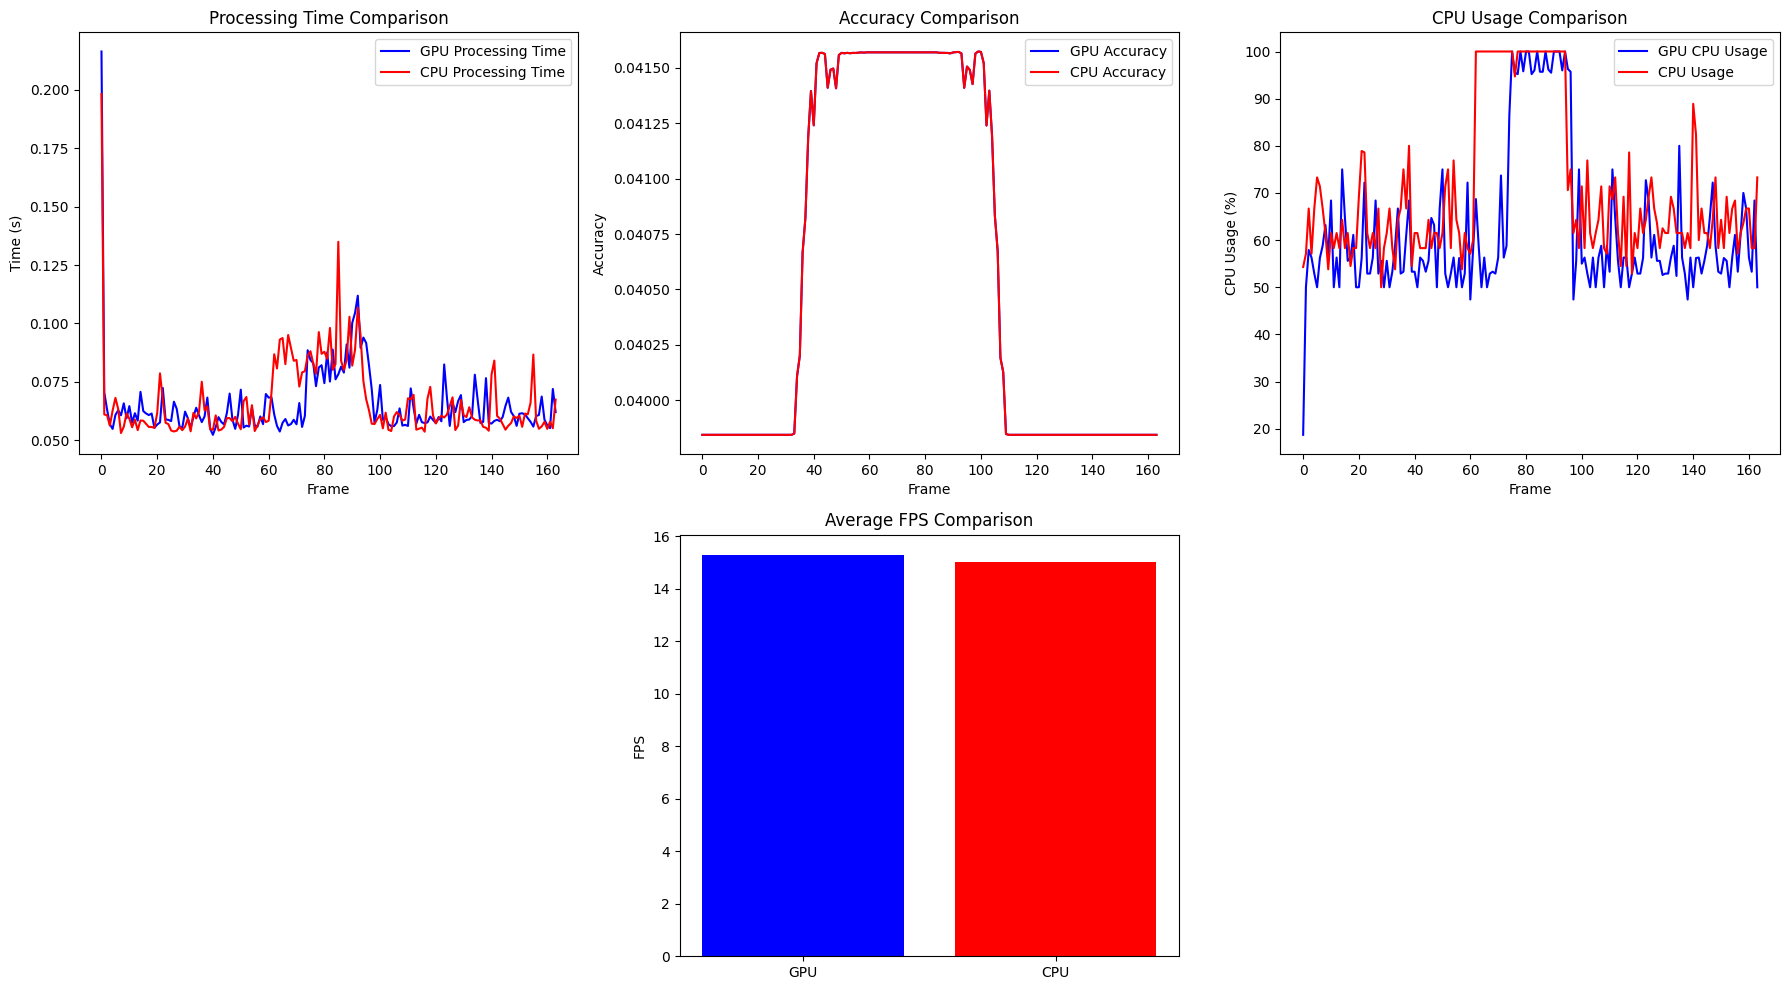

In [ ]:
# Plot performance comparison
def plot_performance_comparison(frame_times_gpu, accuracies_gpu, frame_times_cpu, accuracies_cpu, cpu_usages_gpu, cpu_usages_cpu, gpu_usages):
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.plot(frame_times_gpu, label='GPU Processing Time', color='blue')
    plt.plot(frame_times_cpu, label='CPU Processing Time', color='red')
    plt.title('Processing Time Comparison')
    plt.xlabel('Frame')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(accuracies_gpu, label='GPU Accuracy', color='blue')
    plt.plot(accuracies_cpu, label='CPU Accuracy', color='red')
    plt.title('Accuracy Comparison')
    plt.xlabel('Frame')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(cpu_usages_gpu, label='GPU CPU Usage', color='blue')
    plt.plot(cpu_usages_cpu, label='CPU Usage', color='red')
    plt.title('CPU Usage Comparison')
    plt.xlabel('Frame')
    plt.ylabel('CPU Usage (%)')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.bar(['GPU', 'CPU'], [fps_gpu, fps_cpu], color=['blue', 'red'])
    plt.title('Average FPS Comparison')
    plt.ylabel('FPS')

    plt.tight_layout()
    plt.show()

plot_performance_comparison(frame_times_gpu, accuracies_gpu, frame_times_cpu, accuracies_cpu, cpu_usages_gpu, cpu_usages_cpu, gpu_usages)



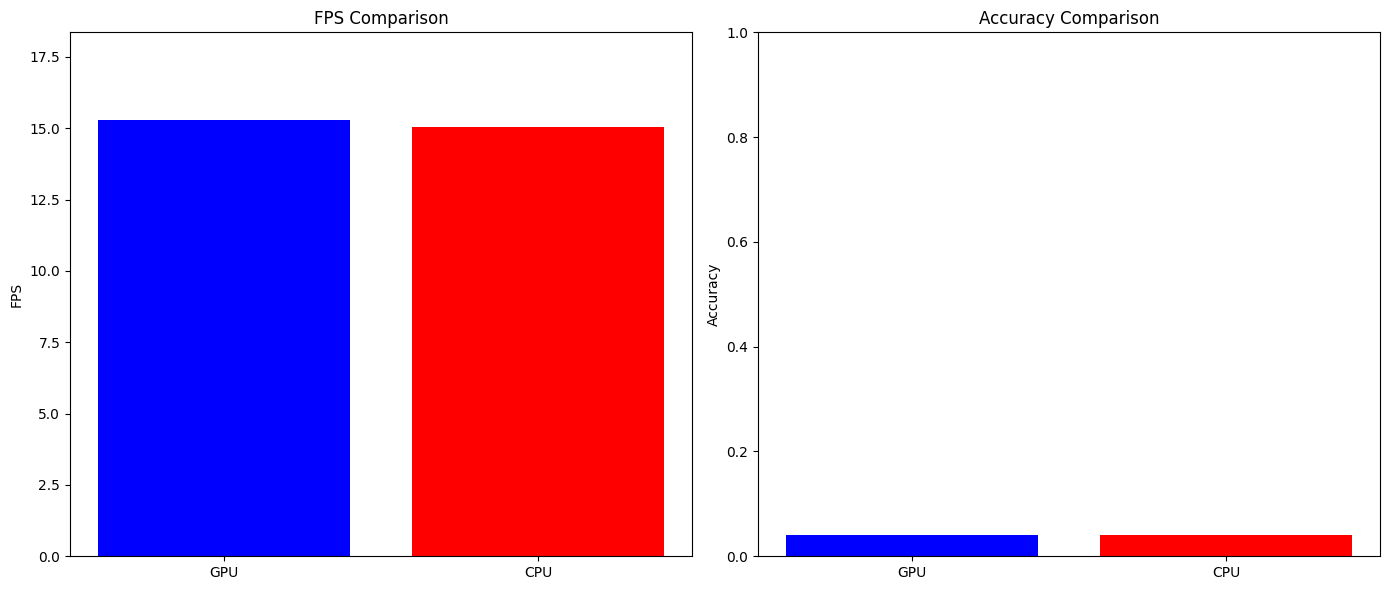

In [ ]:
def plot_fps_accuracy_comparison(fps_gpu, fps_cpu, accuracies_gpu, accuracies_cpu):
    # Calculate average accuracy
    avg_accuracy_gpu = np.mean(accuracies_gpu)
    avg_accuracy_cpu = np.mean(accuracies_cpu)

    # Create a bar plot for FPS and Accuracy comparison
    labels = ['GPU', 'CPU']
    fps_values = [fps_gpu, fps_cpu]
    accuracy_values = [avg_accuracy_gpu, avg_accuracy_cpu]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # FPS comparison
    axs[0].bar(labels, fps_values, color=['blue', 'red'])
    axs[0].set_title('FPS Comparison')
    axs[0].set_ylabel('FPS')
    axs[0].set_ylim([0, max(fps_values) * 1.2])

    # Accuracy comparison
    axs[1].bar(labels, accuracy_values, color=['blue', 'red'])
    axs[1].set_title('Accuracy Comparison')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim([0, 1])  # Assuming accuracy ranges between 0 and 1

    plt.tight_layout()
    plt.show()

# Call the function to plot the bar graphs for FPS and Accuracy
plot_fps_accuracy_comparison(fps_gpu, fps_cpu, accuracies_gpu, accuracies_cpu)


In [ ]:
print("Performance Evaluation:")
print(f"FPS (GPU): {fps_gpu:.2f}")
print(f"FPS (CPU): {fps_cpu:.2f}")
print(f"Average CPU Usage (GPU mode): {np.mean(cpu_usages_gpu):.2f}%")
print(f"Average CPU Usage (CPU mode): {np.mean(cpu_usages_cpu):.2f}%")

Performance Evaluation:
FPS (GPU): 15.30
FPS (CPU): 15.03
Average CPU Usage (GPU mode): 62.49%
Average CPU Usage (CPU mode): 70.84%


In [ ]:
# Convert and display videos side by side
clip_gpu = mp.VideoFileClip("output_video_gpu.avi")
clip_gpu.write_videofile("output_video_gpu.mp4", codec="libx264")

clip_cpu = mp.VideoFileClip("output_video_cpu.avi")
clip_cpu.write_videofile("output_video_cpu.mp4", codec="libx264")

def play_video_side_by_side(video_path1, video_path2):
    mp4_1 = open(video_path1, 'rb').read()
    data_url_1 = "data:video/mp4;base64," + b64encode(mp4_1).decode()

    mp4_2 = open(video_path2, 'rb').read()
    data_url_2 = "data:video/mp4;base64," + b64encode(mp4_2).decode()

    return HTML(f"""
    <div style="display: flex; justify-content: space-around;">
        <div style="margin-right: 10px;">
            <h3>GPU Video</h3>
            <video width="400" controls autoplay muted>
                <source src="{data_url_1}" type="video/mp4">
            </video>
        </div>
        <div>
            <h3>CPU Video</h3>
            <video width="400" controls autoplay muted>
                <source src="{data_url_2}" type="video/mp4">
            </video>
        </div>
    </div>
    """)
# Display both videos side by side
play_video_side_by_side('output_video_gpu.mp4', 'output_video_cpu.mp4')



Moviepy - Building video output_video_gpu.mp4.
Moviepy - Writing video output_video_gpu.mp4



Moviepy - Done !
Moviepy - video ready output_video_gpu.mp4
Moviepy - Building video output_video_cpu.mp4.
Moviepy - Writing video output_video_cpu.mp4



Moviepy - Done !
Moviepy - video ready output_video_cpu.mp4
